<a href="https://colab.research.google.com/github/tnzmnjm/christmas-coding-challenge-2024/blob/main/notebooks/Day%2011/Pytorch_day11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

# Creating a small toy dataset
X_train = torch.tensor([
    [-1.2, 3.1],
    [-0.9, 2.9],
    [-0.5, 2.6],
    [2.3, -1.1],
    [2.7, -1.5]
])

y_train = torch.tensor([0, 0, 0, 1, 1])

x_test = torch.tensor([
    [-0.8, 2.8],
    [2.6, -1.6],])

y_test = torch.tensor([0, 1])

In [2]:
# Defining a custom Dataset class
from torch.utils.data import Dataset

class ToyDataset(Dataset):
  def __init__(self, X, y):
    self.features = X
    self.labels = y

  def __getitem__(self, index):
    one_x = self.features[index]
    one_y = self.labels[index]
    return one_x, one_y

  def __len__(self):
    return self.labels.shape[0]


train_ds = ToyDataset(X_train, y_train)
test_ds = ToyDataset(x_test, y_test)

In [4]:
# Instantiating data loaders
from torch.utils.data import DataLoader

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0)


test_loader = DataLoader(
    dataset=test_ds,
    batch_size=2,
    shuffle=False,
    num_workers=0
)

In [5]:
for idx, (x, y) in enumerate(train_loader):
    print(f"Batch {idx+1}:", x, y)

Batch 1: tensor([[ 2.3000, -1.1000],
        [-0.9000,  2.9000]]) tensor([1, 0])
Batch 2: tensor([[-1.2000,  3.1000],
        [-0.5000,  2.6000]]) tensor([0, 0])
Batch 3: tensor([[ 2.7000, -1.5000]]) tensor([1])


As we can see based on the preceding output, the `train_loader` iterates over the training dataset, **visiting each training example exactly once**. This is known as a **training epoch**. Since we seeded the random number generator using `torch.manual_seed(123)` here, you should get the exact same shuffling order of training examples. However, if you iterate over the dataset a second time, you will see that the shuffling order will change. This is desired to prevent deep neural networks from getting caught in repetitive update cycles during training.

We specified a batch size of 2 here, but the third batch only contains a single example. That’s because we have five training examples, and 5 is not evenly divisible by 2. In practice, having a substantially smaller batch as the last batch in a training epoch **can disturb the convergence** during training. To prevent this, set `drop_last=True`, which will drop the last batch in each epoch, as shown in the following listing.

In [8]:
train_loader = DataLoader(
    dataset=train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

In [9]:
for idx, (x, y) in enumerate(train_loader):
    print(f"Batch {idx+1}:", x, y)

Batch 1: tensor([[-0.9000,  2.9000],
        [ 2.3000, -1.1000]]) tensor([0, 1])
Batch 2: tensor([[ 2.7000, -1.5000],
        [-0.5000,  2.6000]]) tensor([1, 0])


## Understanding CPU vs GPU processing
CPU (Central Processing Unit):

- Architecture: Has a few powerful cores optimised for sequential processing
- Versatility: Can handle many different types of tasks
- Memory Access: Direct access to RAM, good for tasks requiring lots of memory operations
- Best for: Tasks that can't be parallelised, complex decision making, single-threaded operations

GPU (Graphics Processing Unit):

- Architecture: Has thousands of simpler cores designed for parallel processing
- Specialisation: Optimised for mathematical operations on matrices
- Memory Access: Has its own high-bandwidth memory but needs to transfer data from RAM
- Best for: Deep learning, matrix operations, parallel computations


## CPU-Only Environment:
When you only have a CPU, the `num_workers` parameter still matters for performance. Here's why: Even with just a CPU, your computer can run multiple processes in parallel. Think of it like having multiple workers in a kitchen - even if there's only one stove (the CPU for computation), having multiple people prep ingredients (load data) can still speed things up. When `num_workers=0`, it's like having one person both prepping ingredients and cooking. With `num_workers>0`, you have separate people handling the prep work.

## CPU + GPU Environment:
This is where `num_workers` becomes especially powerful. The GPU is extremely fast at processing data, but it needs that **data to be fed to it quickly**. Think of the GPU as a super-fast chef who can cook dishes instantly, but they need ingredients prepared and ready. When `num_workers=0`, one worker has to prep everything, creating a bottleneck. With multiple workers, data preparation happens in parallel, keeping the GPU fed with data.

The setting `num_workers=0` in the `DataLoader`. This parameter in PyTorch’s `DataLoader` function is crucial for **parallelising data loading** and **preprocessing**. When `num_workers` is set to `0`, the data loading will be done in the main process and not in separate worker processes. This might seem unproblematic, but it can lead to significant slowdowns during model training when we train larger networks on a GPU. Instead of focusing solely on the processing of the deep learning model, the CPU must also take time to load and preprocess the data. As a result, the GPU can sit idle while waiting for the CPU to finish these tasks. In contrast, when `num_workers` is set to a number greater than 0, multiple worker processes are launched to load data in parallel, freeing the main process to focus on training your model and better utilizing your system’s resources.

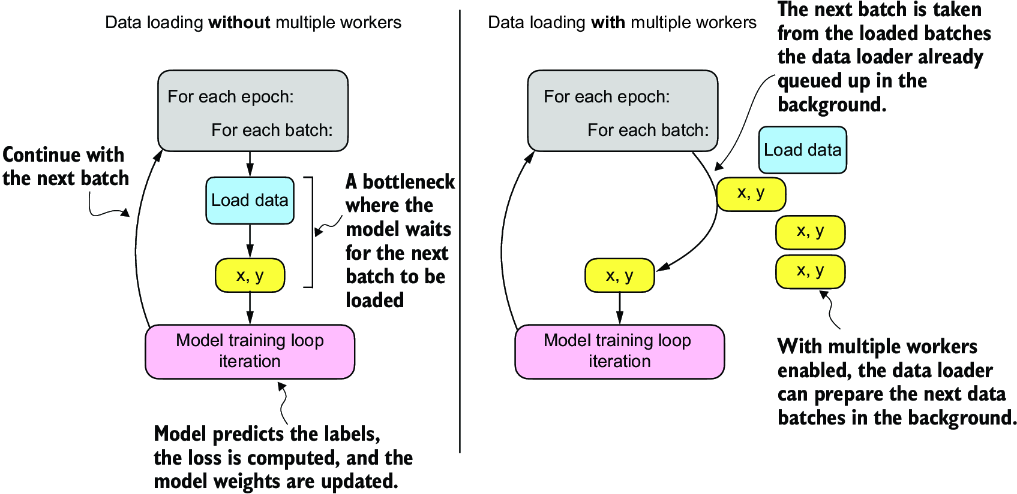

In [13]:
from IPython.display import Image
Image('/content/drive/MyDrive/Data science/Build a Large Language Model (From Scratch)/Pytorch/images/dataloader_with_without_multiple_workers.png')


Loading data without multiple workers (setting `num_workers=0`) will create a data loading bottleneck where the model sits idle until the next batch is loaded (left). If multiple workers are enabled, the data loader can queue up the next batch in the background (right).

However, if we are working with very small datasets, setting `num_workers` to 1 or larger may not be necessary since the total training time takes only fractions of a second anyway. So, if you are working with tiny datasets or interactive environments such as Jupyter notebooks, increasing `num_workers` may not provide any noticeable speedup. It may, in fact, lead to some problems. One potential problem is the overhead of spinning up multiple worker processes, which could take longer than the actual data loading when your dataset is small.

Furthermore, for Jupyter notebooks, setting `num_workers` to greater than 0 can sometimes lead to problems related to the sharing of resources between different processes, resulting in errors or notebook crashes. Therefore, it’s essential to understand the tradeoff and make a calculated decision on setting the `num_workers` parameter. When used correctly, it can be a beneficial tool but should be adapted to your specific dataset size and computational environment for optimal results.